In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
# imports
import pprint
import pickle
import glob
import random
from pathlib import Path
import math

import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from tqdm.autonotebook import tqdm

from utils import general_utils
from utils import eval_utils
from deformation import losses

In [4]:
#class_ids = ["test"]
class_ids = ["02691156", "02828884", "02933112", "02958343", "03001627", "03211117", "03636649", "03691459", "04090263", "04256520", "04379243", "04401088", "04530566"]
sym_results_df = pd.DataFrame()
for class_id in tqdm(class_ids):
    sym_results = pickle.load(open("data_prep_tools/check_symmetry_results/{}.p".format(class_id), "rb"))
    for path in sym_results:
        instance = path.split('/')[-2]
        sym_loss = sym_results[path]
        entry_dict = {"class": class_id, "instance": instance, "sym_loss": sym_loss}
        sym_results_df = sym_results_df.append(entry_dict, ignore_index=True)

In [5]:
display(sym_results_df.sort_values("sym_loss", ascending=False))

,class,instance,sym_loss
38293,04379243,3712e31c61ea51a354b250a5bdfb0136,3.243314e-02
39809,04379243,f5d87f88bd9b31ad2f0ebd444c10bd0c,3.227737e-02
36500,04379243,ec9861c234daf6bc915f51b5f5e95ffa,3.225997e-02
37489,04379243,f7ced3de6f4c1ffb4e3935c6cee4b35,3.106036e-02
13766,02958343,11435a2eccd6342e78cdc913b1ba578b,3.067863e-02
...,...,...,...
22548,03211117,23c99db82c910931e2c8e43c97ec5a85,3.238814e-05
22368,03211117,877cadd597775369ec059109909662d2,2.567960e-05
41602,04401088,ef2b505068cf120efe48f52a0ccc160d,2.432552e-05
22789,03211117,aa99cc4323af7144e7321f25048c6142,1.955101e-05


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6efaa406a0>]],
      dtype=object)

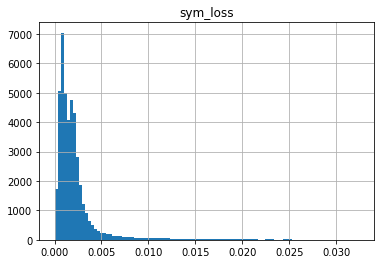

In [6]:
sym_results_df.hist(column="sym_loss", bins=100)

In [9]:
for class_id in class_ids:
    n = len(sym_results_df[(sym_results_df["class"] == class_id) & (sym_results_df["sym_loss"] > 0.01)])
    print("{} -- {}".format(class_id, n))

02691156 -- 9
02828884 -- 36
02933112 -- 3
02958343 -- 42
03001627 -- 72
03211117 -- 7
03636649 -- 47
03691459 -- 57
04090263 -- 16
04256520 -- 569
04379243 -- 369
04401088 -- 15
04530566 -- 17


04256520 -- d58a2c86b9b71f6bef4e42d70375aed8 -- 0.03009398840367794


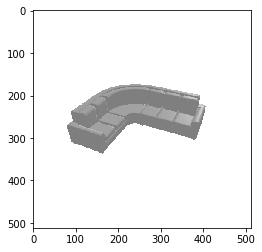

04256520 -- 1193da9a06f87fd6a0064771a6f2cf3b -- 0.029097657650709152


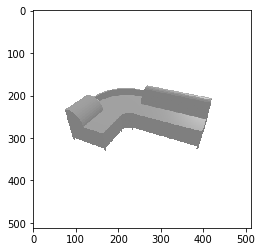

04256520 -- 64c8591e8a837cd5dc8d41086ec55d96 -- 0.02899174764752388


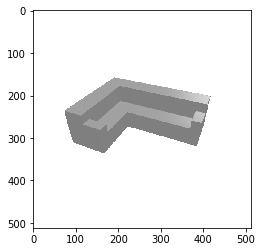

04256520 -- 575876c91251e1923d6e282938a47f9e -- 0.028169646859169006


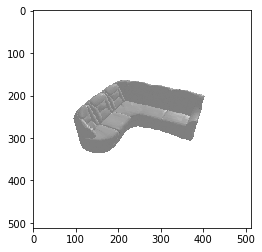

04256520 -- 664a84b65396e168707aff99601b0e71 -- 0.02805207297205925


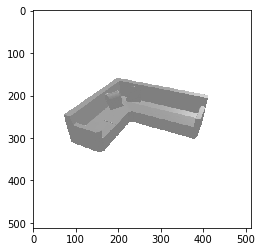

04256520 -- 96055e2a648903bbaf2302630d34f30e -- 0.02801472507417202


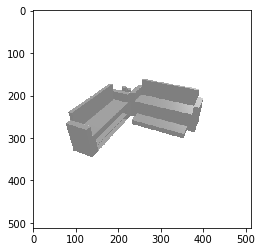

04256520 -- 7b9d9c738c6042ad1c2c02171f63f02f -- 0.0276789553463459


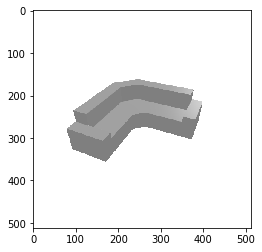

04256520 -- b4a72257eff26336d7231c5bdc5ab135 -- 0.027665644884109497


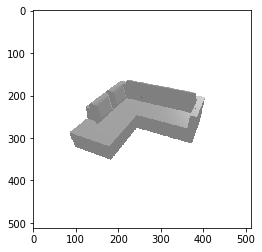

04256520 -- 16fd88a99f7d4c857e484225f3bb4a8 -- 0.02759621851146221


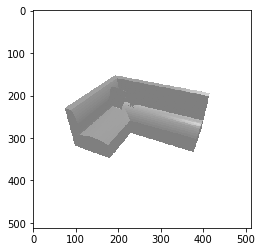

04256520 -- 19f0a14207f4f953bb1b55ae5bd11e93 -- 0.02747318521142006


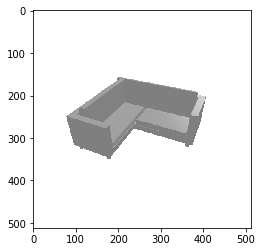

04256520 -- e68e91ef2652cd1c36e3b2fa8d1eb4eb -- 0.02725428156554699


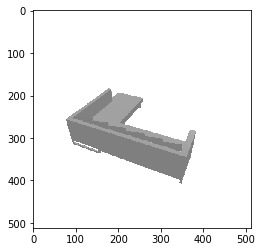

In [14]:
device = torch.device("cuda:0")
shapenet_dir = "/home/svcl-oowl/dataset/ShapeNetCore.v1"
dist = 1.3
elev = 35
azim = 25
R, T = look_at_view_transform(dist, elev, azim) 
num_show = 10


#for class_id in class_ids:
for class_id in ["04256520"]:
    i = 0
    for _, row in sym_results_df[(sym_results_df["class"] == class_id) & (sym_results_df["sym_loss"] > 0.01)].sort_values("sym_loss", ascending=False).iterrows():
        class_id = row["class"]
        instance = row["instance"]
        sym_loss = row["sym_loss"]
        print("{} -- {} -- {}".format(class_id, instance, sym_loss))
        
        model_path = os.path.join(shapenet_dir, class_id, instance, "model_watertight.obj")
        mesh = general_utils.load_untextured_mesh(model_path, device)
        render = general_utils.render_mesh(mesh, R, T, device)
        plt.imshow(render[0, ..., :3].detach().cpu().numpy())
        plt.show()
        
        i+=1
        if i > num_show:
            break
        
    



In [51]:
# create lists

output_dir = "data_prep_tools/occnet_test_set_lists"
shapenet_dir = "/home/svcl-oowl/dataset/ShapeNetCore.v1"

num_save = 20

for class_id in class_ids:
    i = 0
    with open(os.path.join(output_dir, "sym_{}.lst".format(class_id)), "w") as f:
        for _, row in sym_results_df[(sym_results_df["class"] == class_id) & (sym_results_df["sym_loss"] > 0.01)].sort_values("sym_loss", ascending=False).iterrows():
            instance = row["instance"]
            f.write("{}\n".format(instance))

            i+=1
            if i >= num_save:
                break
        